# Laboratorio 1: Comparación de algoritmos de Series de Tiempo

## 1. Importar librerías

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, ExponentialSmoothing
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error, mean_absolute_error
import pmdarima as pm
from prophet import Prophet

# Configuración global de gráficos
sns.set_style('whitegrid')

ValueError: numpy.dtype size changed, may indicate binary incompatibility. Expected 96 from C header, got 88 from PyObject

## 2. Funciones auxiliares

In [4]:
def plot_series(series, title=None):
    plt.figure(figsize=(12, 5))
    plt.plot(series)
    if title:
        plt.title(title)
    plt.show()

def evaluate_forecast(actual, predicted):
    rmse = np.sqrt(mean_squared_error(actual, predicted))
    mae = mean_absolute_error(actual, predicted)
    return {'RMSE': rmse, 'MAE': mae}

## 3. Análisis por conjunto de datos

### 3.1 Conjunto de Datos 1: daily-total-female-births.csv

In [5]:
df1 = pd.read_csv('daily-total-female-births.csv', parse_dates=['Date'], index_col='Date')

#### 3.1.1 Análisis Exploratorio
#### - Describir la serie (tendencia, estacionalidad)
#### - Visualizar

           Births
count  365.000000
mean    41.980822
std      7.348257
min     23.000000
25%     37.000000
50%     42.000000
75%     46.000000
max     73.000000


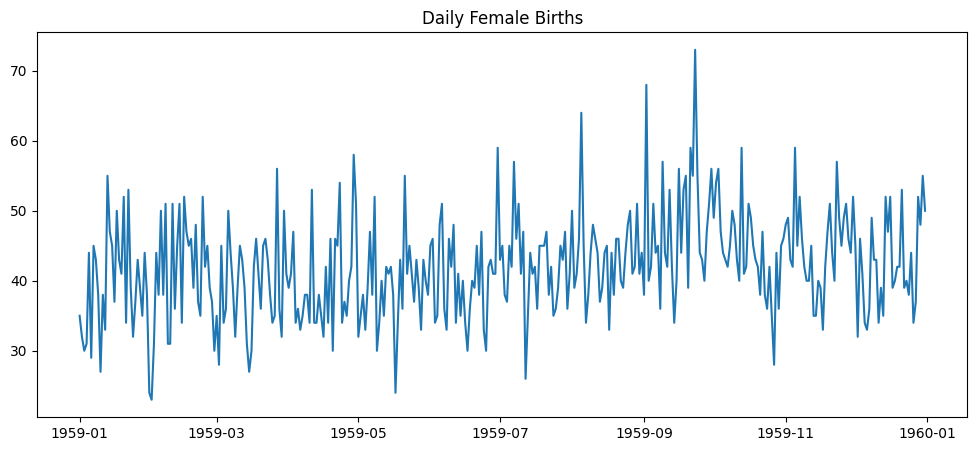

In [6]:
print(df1.describe())
plot_series(df1['Births'], 'Daily Female Births')

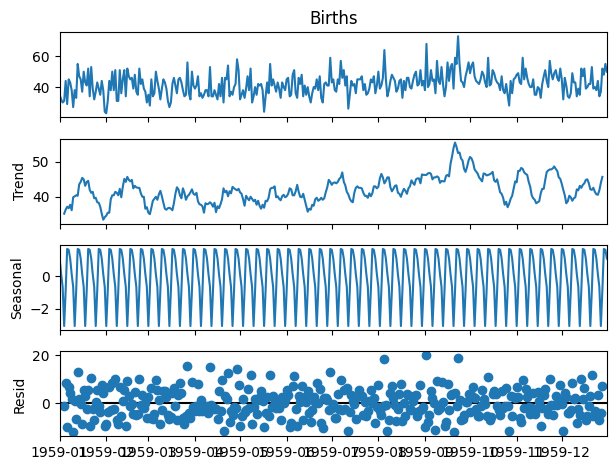

In [7]:
result = seasonal_decompose(df1['Births'], model='additive', period=7)
result.plot(); plt.show()

#### 3.1.2 Promedios Móviles

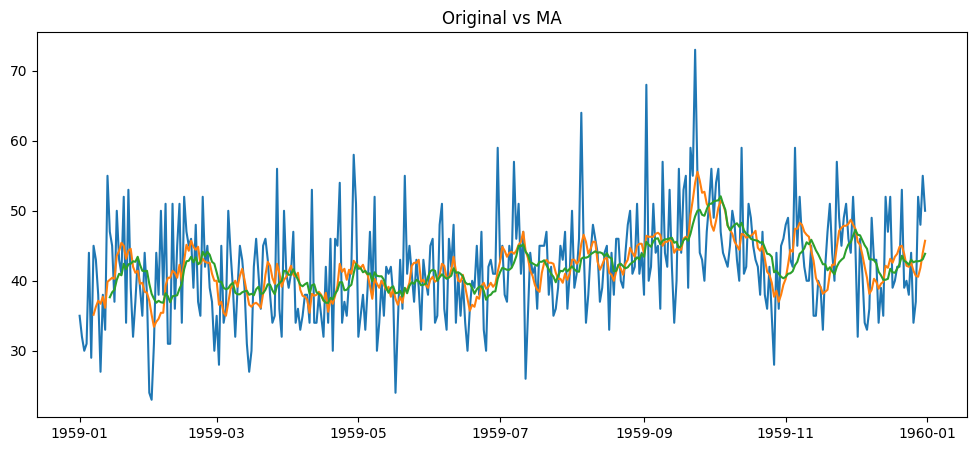

In [8]:
for window in [7, 14, 30]:
    df1[f'MA_{window}'] = df1['Births'].rolling(window=window).mean()
plot_series(df1[['Births', 'MA_7', 'MA_14']], 'Original vs MA')

#### 3.1.3 Suavizado Exponencial

c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


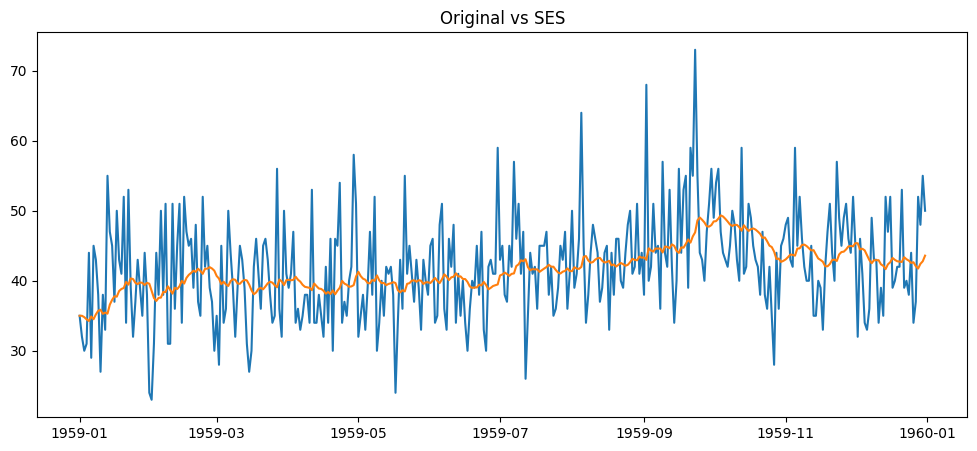

In [9]:
# Simple Exponential Smoothing
ses = SimpleExpSmoothing(df1['Births']).fit()
df1['SES'] = ses.fittedvalues
plot_series(df1[['Births', 'SES']], 'Original vs SES')

#### 3.1.4 Holt-Winters

c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


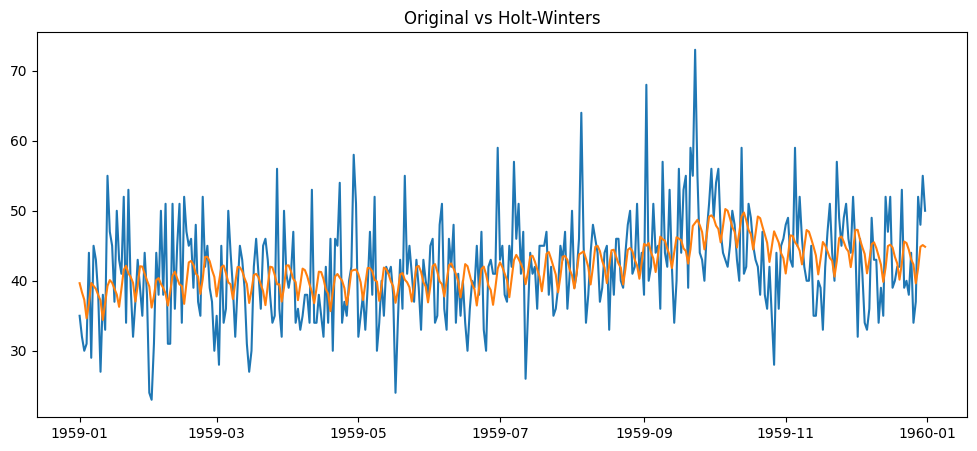

In [10]:
# Additive trend & seasonality
tb_model = ExponentialSmoothing(df1['Births'], trend='add', seasonal='add', seasonal_periods=7).fit()
df1['HW_ADD'] = tb_model.fittedvalues
plot_series(df1[['Births', 'HW_ADD']], 'Original vs Holt-Winters')

#### 3.1.5 SARIMA

In [11]:
# Encontrar parámetros con auto_arima
sarima_auto = pm.auto_arima(df1['Births'], seasonal=True, m=7, trace=True)
print(sarima_auto.summary())
# Ajustar modelo SARIMA(p,d,q)(P,D,Q)[7]
model = SARIMAX(df1['Births'], order=sarima_auto.order, seasonal_order=sarima_auto.seasonal_order).fit(disp=False)
df1['SARIMA_FIT'] = model.fittedvalues
plot_series(df1[['Births', 'SARIMA_FIT']], 'Original vs SARIMA')

NameError: name 'pm' is not defined

#### 3.1.6 Prophet

In [12]:
prophet_df = df1.reset_index().rename(columns={'Date':'ds', 'Births':'y'})
prophet_model = Prophet()
prophet_model.fit(prophet_df)
future = prophet_model.make_future_dataframe(periods=30)
forecast = prophet_model.predict(future)
# Visualizar pronóstico
prophet_model.plot(forecast); plt.show()

NameError: name 'Prophet' is not defined

#### 3.1.7 Evaluación y comparación

In [13]:
# Dividir en train/test (últimos 30 días como prueba)
train, test = df1.iloc[:-30], df1.iloc[-30:]
results = {}

# SES
ses_pred = ses.forecast(30)
results['SES'] = evaluate_forecast(test['Births'], ses_pred)

# Holt-Winters
hw_pred = tb_model.forecast(30)
results['Holt-Winters'] = evaluate_forecast(test['Births'], hw_pred)

# SARIMA
sarima_pred = model.get_forecast(steps=30).predicted_mean
results['SARIMA'] = evaluate_forecast(test['Births'], sarima_pred)

# Prophet
y_pred = forecast.set_index('ds').loc[test.index, 'yhat']
results['Prophet'] = evaluate_forecast(test['Births'], y_pred)

print(pd.DataFrame(results).T)

NameError: name 'model' is not defined

### 3.2 Conjunto de Datos 2: shampoo.csv

C:\Users\user\AppData\Local\Temp\ipykernel_20084\291285923.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df2 = pd.read_csv('shampoo.csv', parse_dates=['Month'], index_col='Month')


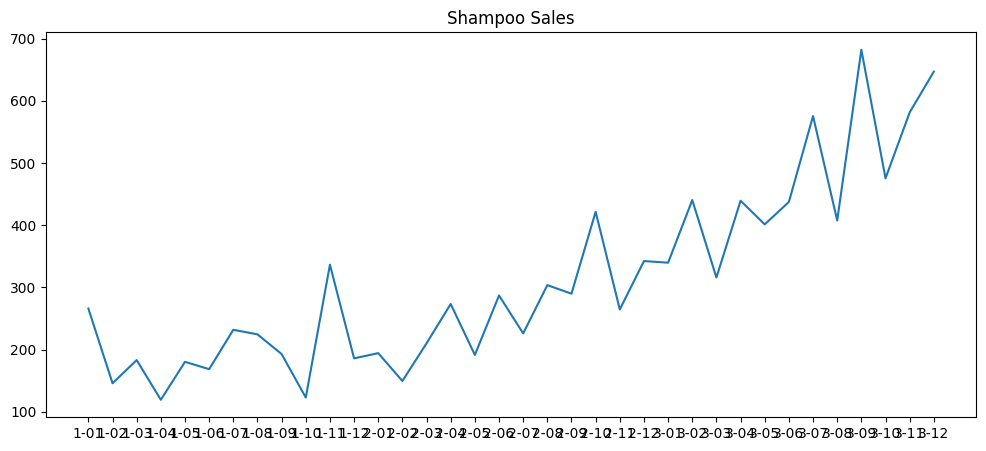

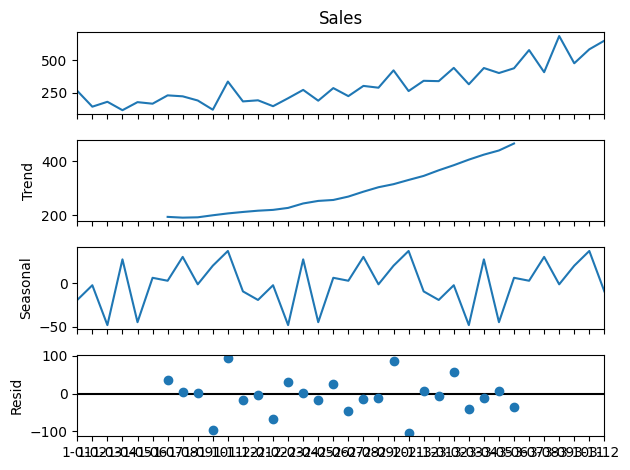

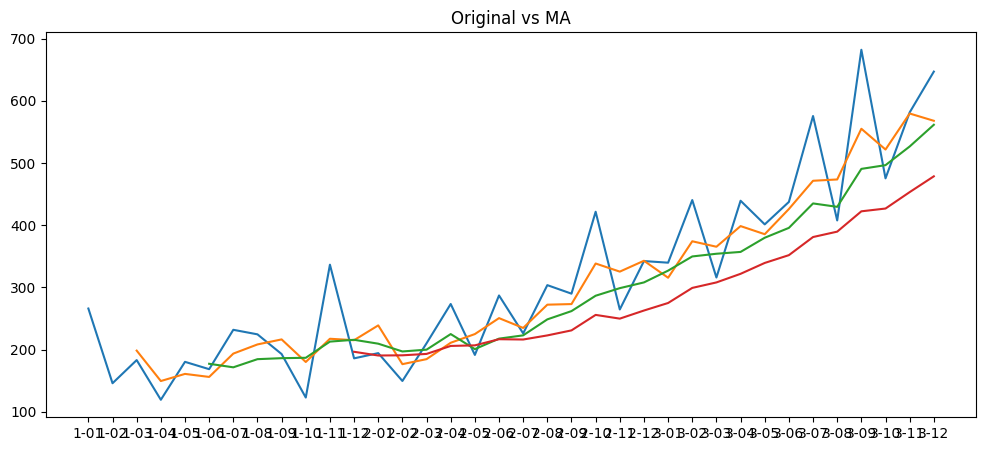

c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:559: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  _index = to_datetime(index)
c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


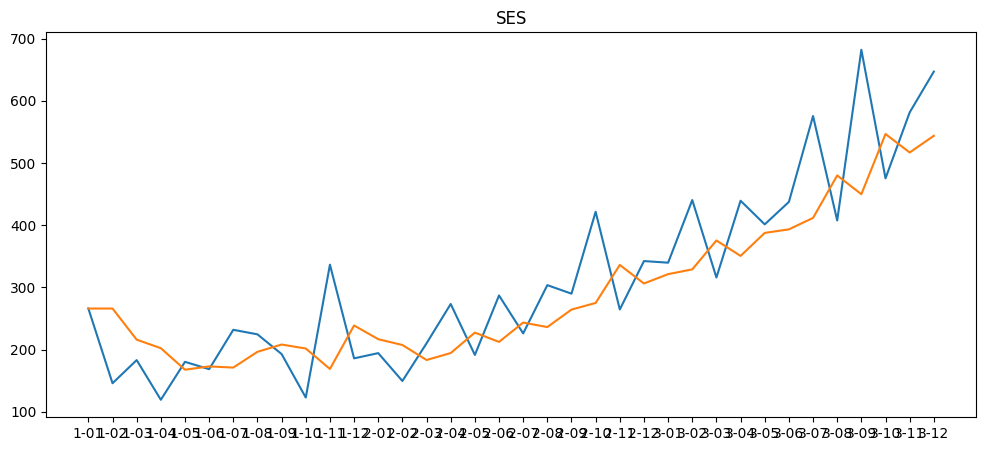

c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:559: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  _index = to_datetime(index)
c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


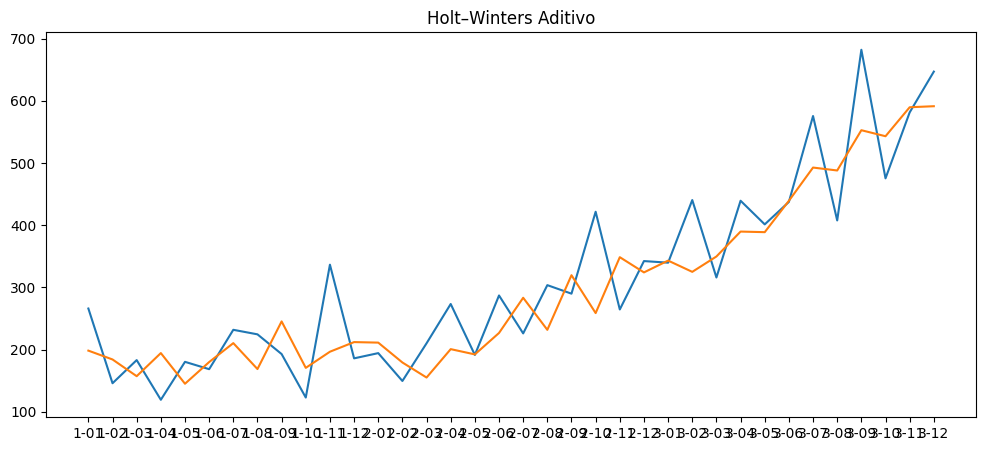

NameError: name 'pm' is not defined

In [14]:
# Lectura y Serie
df2 = pd.read_csv('shampoo.csv', parse_dates=['Month'], index_col='Month')
plot_series(df2['Sales'], 'Shampoo Sales')

# Descomposición estacional (periodo 12 meses)
result2 = seasonal_decompose(df2['Sales'], model='additive', period=12)
result2.plot(); plt.show()

# Promedios móviles (3, 6 y 12 meses)
for w in [3, 6, 12]:
    df2[f'MA_{w}'] = df2['Sales'].rolling(window=w).mean()
plot_series(df2[['Sales', 'MA_3', 'MA_6', 'MA_12']], 'Original vs MA')

# Suavizado Exponencial Simple
ses2 = SimpleExpSmoothing(df2['Sales']).fit()
df2['SES'] = ses2.fittedvalues
plot_series(df2[['Sales','SES']], 'SES')

# Holt-Winters (tendencia y estacionalidad aditivas)
hw2 = ExponentialSmoothing(df2['Sales'],
                          trend='add',
                          seasonal='add',
                          seasonal_periods=12).fit()
df2['HW_ADD'] = hw2.fittedvalues
plot_series(df2[['Sales','HW_ADD']], 'Holt–Winters Aditivo')

# SARIMA (auto_arima para identificación)
sarima2 = pm.auto_arima(df2['Sales'], seasonal=True, m=12, trace=True)
model2 = SARIMAX(df2['Sales'],
                 order=sarima2.order,
                 seasonal_order=sarima2.seasonal_order).fit(disp=False)
df2['SARIMA_FIT'] = model2.fittedvalues
plot_series(df2[['Sales','SARIMA_FIT']], 'SARIMA Fit')

# Prophet
prophet2 = Prophet()
prophet2.fit(df2.reset_index().rename(columns={'Month':'ds','Sales':'y'}))
future2 = prophet2.make_future_dataframe(periods=12, freq='M')
forecast2 = prophet2.predict(future2)
prophet2.plot(forecast2); plt.show()

### 3.3 Conjunto de Datos 3: monthly-mean-temp.csv

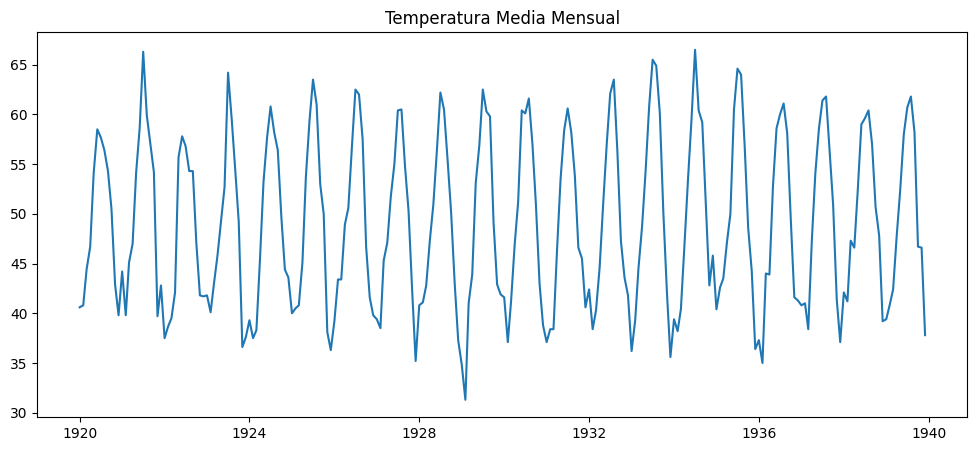

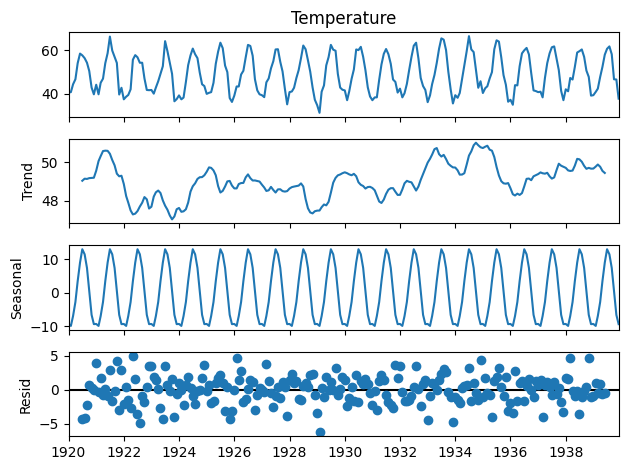

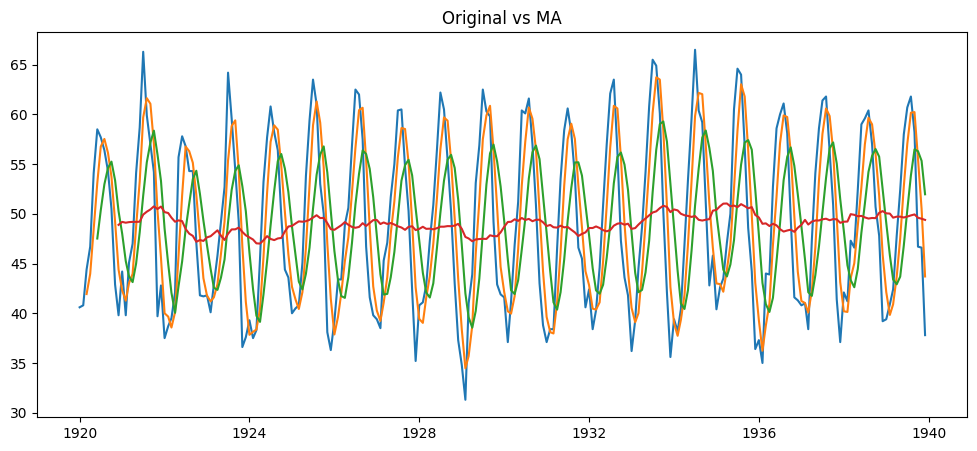

c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


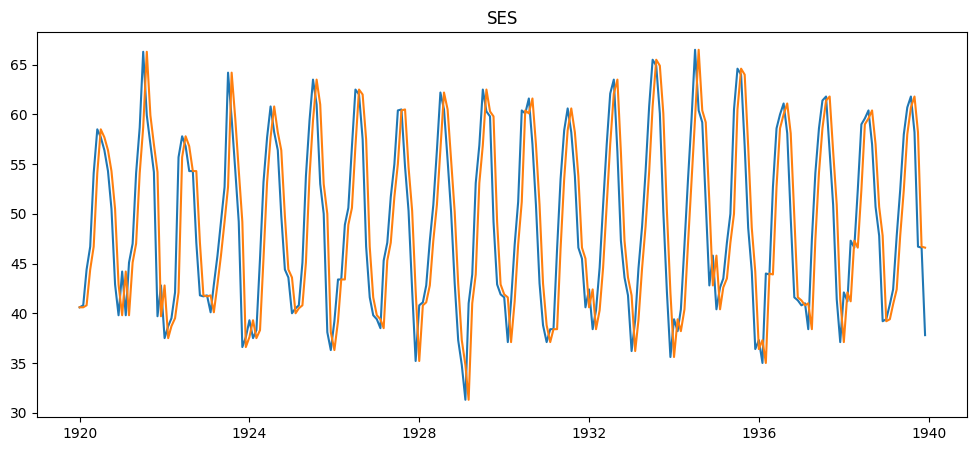

c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


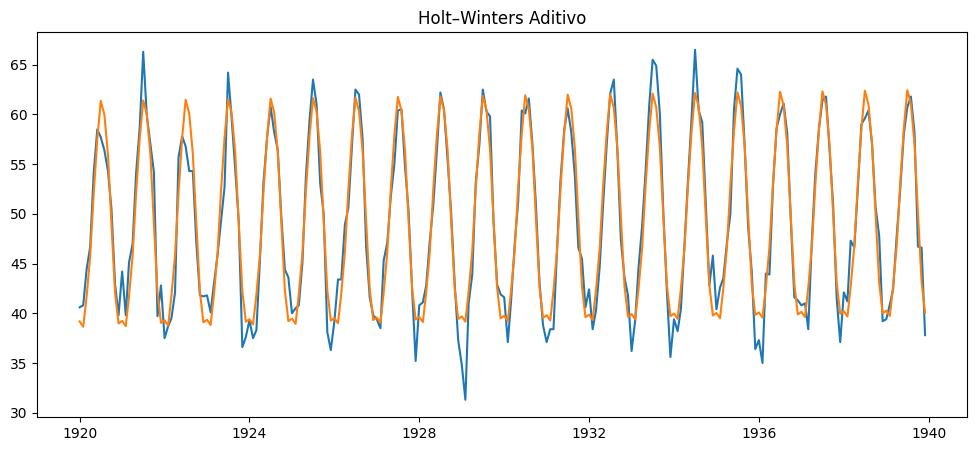

NameError: name 'pm' is not defined

In [18]:
df3 = pd.read_csv('monthly-mean-temp.csv',
                  parse_dates=['Month'], index_col='Month')

# Columna correcta: 'Temperature'
plot_series(df3['Temperature'], 'Temperatura Media Mensual')

# Descomposición estacional
res3 = seasonal_decompose(df3['Temperature'], model='additive', period=12)
res3.plot(); plt.show()

# Promedios móviles
for w in [3, 6, 12]:
    df3[f'MA_{w}'] = df3['Temperature'].rolling(window=w).mean()
plot_series(df3[['Temperature','MA_3','MA_6','MA_12']], 'Original vs MA')

# SES
ses3 = SimpleExpSmoothing(df3['Temperature']).fit()
df3['SES'] = ses3.fittedvalues
plot_series(df3[['Temperature','SES']], 'SES')

# Holt–Winters
hw3 = ExponentialSmoothing(df3['Temperature'],
                           trend='add',
                           seasonal='add',
                           seasonal_periods=12).fit()
df3['HW_ADD'] = hw3.fittedvalues
plot_series(df3[['Temperature','HW_ADD']], 'Holt–Winters Aditivo')

# SARIMA
sarima3 = pm.auto_arima(df3['Temperature'], seasonal=True, m=12, trace=True)
model3 = SARIMAX(df3['Temperature'],
                 order=sarima3.order,
                 seasonal_order=sarima3.seasonal_order).fit(disp=False)
df3['SARIMA_FIT'] = model3.fittedvalues
plot_series(df3[['Temperature','SARIMA_FIT']], 'SARIMA Fit')

# Prophet
prophet3 = Prophet()
prophet3.fit(df3.reset_index().rename(columns={'Month':'ds','Temperature':'y'}))
future3 = prophet3.make_future_dataframe(periods=12, freq='M')
forecast3 = prophet3.predict(future3)
prophet3.plot(forecast3); plt.show()

### 3.4 Conjunto de Datos 4: monthly-car-sales.csv

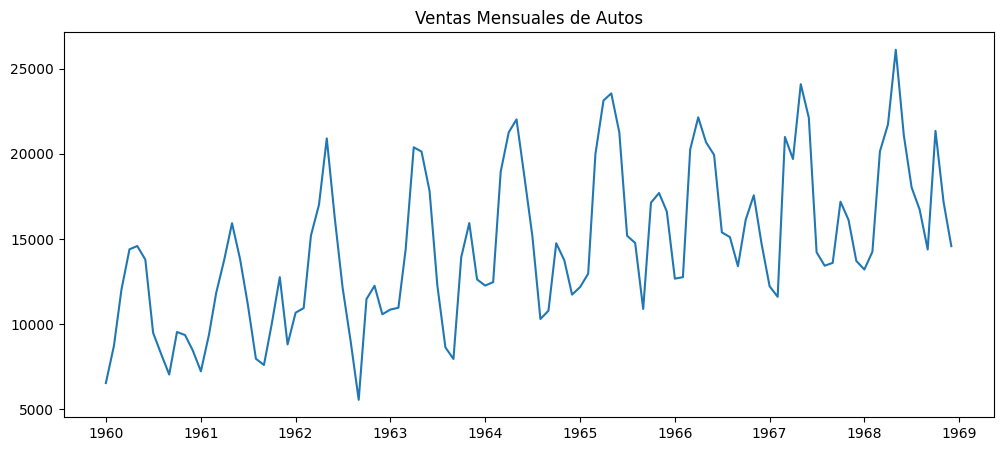

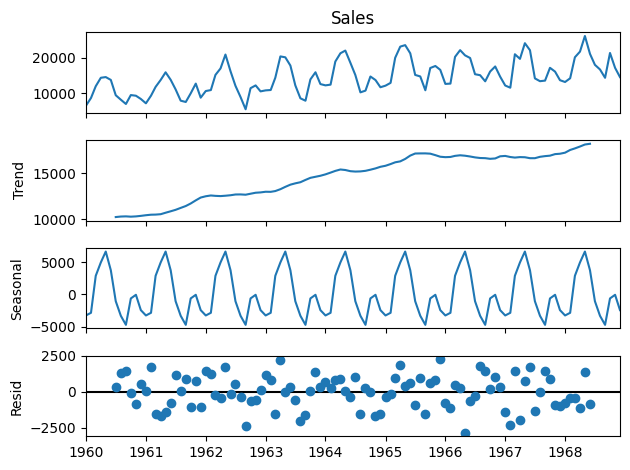

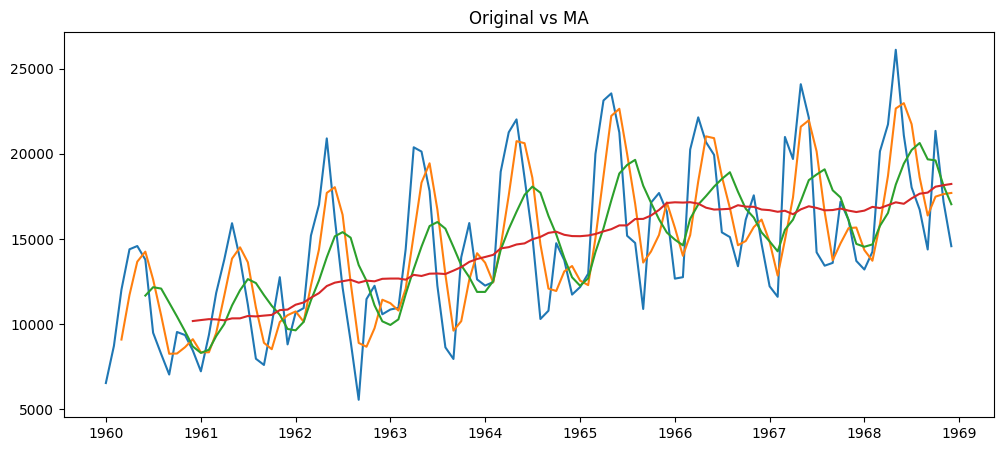

c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


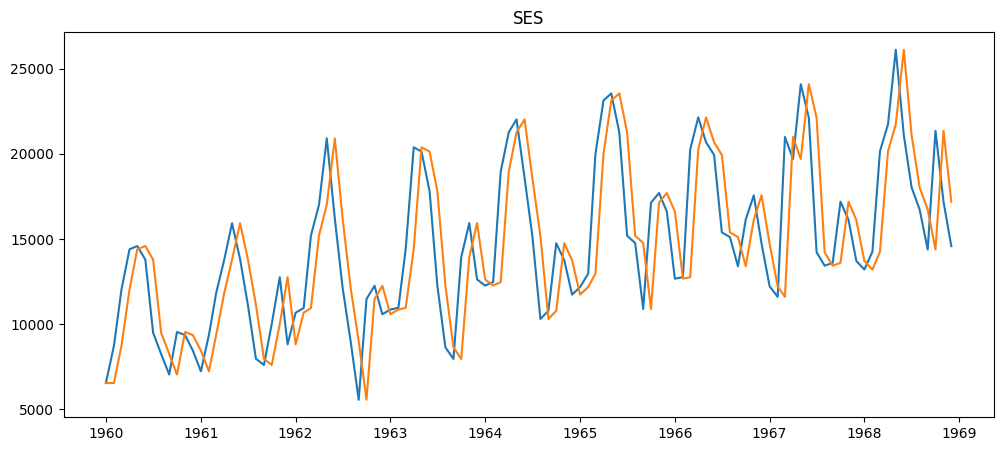

c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


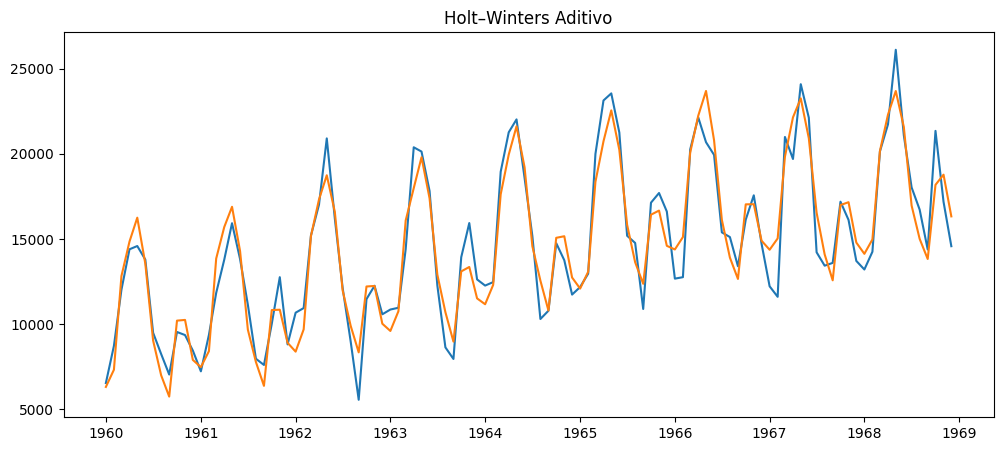

NameError: name 'pm' is not defined

In [16]:
df4 = pd.read_csv('monthly-car-sales.csv',
                  parse_dates=['Month'], index_col='Month')
plot_series(df4['Sales'], 'Ventas Mensuales de Autos')

# Descomposición estacional (periodo 12)
res4 = seasonal_decompose(df4['Sales'], model='additive', period=12)
res4.plot(); plt.show()

# Promedios móviles (3, 6, 12 meses)
for w in [3, 6, 12]:
    df4[f'MA_{w}'] = df4['Sales'].rolling(window=w).mean()
plot_series(df4[['Sales','MA_3','MA_6','MA_12']], 'Original vs MA')

# SES
ses4 = SimpleExpSmoothing(df4['Sales']).fit()
df4['SES'] = ses4.fittedvalues
plot_series(df4[['Sales','SES']], 'SES')

# Holt–Winters con estacionalidad
hw4 = ExponentialSmoothing(df4['Sales'],
                          trend='add',
                          seasonal='add',
                          seasonal_periods=12).fit()
df4['HW_ADD'] = hw4.fittedvalues
plot_series(df4[['Sales','HW_ADD']], 'Holt–Winters Aditivo')

# SARIMA (auto_arima)
sarima4 = pm.auto_arima(df4['Sales'], seasonal=True, m=12, trace=True)
model4 = SARIMAX(df4['Sales'],
                 order=sarima4.order,
                 seasonal_order=sarima4.seasonal_order).fit(disp=False)
df4['SARIMA_FIT'] = model4.fittedvalues
plot_series(df4[['Sales','SARIMA_FIT']], 'SARIMA Fit')

# Prophet
prophet4 = Prophet()
prophet4.fit(df4.reset_index().rename(columns={'Month':'ds','Sales':'y'}))
future4 = prophet4.make_future_dataframe(periods=12, freq='M')
forecast4 = prophet4.predict(future4)
prophet4.plot(forecast4); plt.show()